# Train an agent on a Graph Coloring problem

We are going to see how to use `SeaPearl.jl`/`SeaPearl.jl` to create a Reinforcement Learning Agent that will work as value-selection heuristic, train it to solve generated graph coloring problem instances, and eventually evaluate its performances against a basic heuristic.

## Dealing with dependencies

Here, we'll start by activating an independant environment, and install the necessary dependencies.
After that, we need to include them in our main namespace, to be able to work with them.

The most important one here is clearly `SeaPearl`. Then, we have:
- `ReinforcementLearning` (that is renamed to `RL`) that will be used to create our RL agent, it automates things like $\epsilon$-greedy explorers or DQN learner.
- `Flux` is the Julia Machine Learning library we use, it could be considered kind of equivalent to something like Pytorch (but does not work the same way at all!)
- `GeometricFlux` is a small library that defines some graph neural networks layers that we can use, such as the GCNConv
- `Plots` (followed by a call to `gr()` specifying which backend we want) will let us plot some results in that notebook

In [1]:
using SeaPearl
using ReinforcementLearning
const RL = ReinforcementLearning
using Flux
using GeometricFlux

using Plots
gr()

┌ Warning: `haskey(::TargetIterator, name::String)` is deprecated, use `Target(; name = name) !== nothing` instead.
│   caller = llvm_compat(::VersionNumber) at compatibility.jl:176
└ @ CUDAnative C:\Users\ilanc\.julia\packages\CUDAnative\C91oY\src\compatibility.jl:176


Plots.GRBackend()

## Deciding which problem we are going to work on

Here we define a generator called GraphColoring generator. You can go check in the source pretty easily, but this generator will basically create **graph coloring instances** with **10 nodes**, and a **density of 1.4**.


What we think will be useful is that, making sure you implement the interface we will document, you can **replace this generator with your own**. This allows you to train your agents on pretty much *everything* you want, assuming your problems can be expressed using the constraints we already implemented (of course since this is an open-source project, adding new constraints shouldn't be too difficult).

In [2]:
coloring_generator = SeaPearl.GraphColoringGenerator(10, 1.4)

SeaPearl.GraphColoringGenerator(10, 1.4)

The following cell could be considered a bit obscure. Those are informations our solver cannot already guess on its own (we are working on it). It is the shape of the features of the graph, and the shape of the state representation when it is transformed into an array to be stacked into the array buffer.

In [3]:
numInFeatures = 3
numberOfCPNodes = 1 + floor(Int64, coloring_generator.nb_nodes * ( 3 + coloring_generator.density ))
state_size = (numberOfCPNodes, numInFeatures + numberOfCPNodes + 2 + 1, 1)

(45, 51, 1)

## Create our value-selection heuristics

### Create our trainable heuristic

Here we create a RL agent with a lot of different hyperparamaters. The most important lines would be the definition of the `approximator` and the `target_approximator`. The model inside them are of the same architecture. It is a two-layers GCNConv followed by two Dense layers. We here use the `FlexGNN` structure that allows us to easily change between structures.

In [4]:
agent = RL.Agent(
    policy = RL.QBasedPolicy(
        learner = SeaPearl.CPDQNLearner(
            approximator = RL.NeuralNetworkApproximator(
                model = SeaPearl.FlexGNN(
                    graphChain = Flux.Chain(
                        GeometricFlux.GCNConv(numInFeatures => 20),
                        GeometricFlux.GCNConv(20 => 20),
                    ),
                    nodeChain = Flux.Chain(
                        Flux.Dense(20, 20),
                    ),
                    outputLayer = Flux.Dense(20, 10)
                ),
                optimizer = ADAM(0.0005f0)
            ),
            target_approximator = RL.NeuralNetworkApproximator(
                model = SeaPearl.FlexGNN(
                    graphChain = Flux.Chain(
                        GeometricFlux.GCNConv(numInFeatures => 20),
                        GeometricFlux.GCNConv(20 => 20),
                    ),
                    nodeChain = Flux.Chain(
                        Flux.Dense(20, 20),
                    ),
                    outputLayer = Flux.Dense(20, 10)
                ),
                optimizer = ADAM(0.0005f0)
            ),
            loss_func = huber_loss,
            stack_size = nothing,
            γ = 0.9999f0,
            batch_size = 1, #32,
            update_horizon = 25,
            min_replay_history = 1,
            update_freq = 10,
            target_update_freq = 200,
            seed = 22,
        ), 
        explorer = SeaPearl.CPEpsilonGreedyExplorer(
            ϵ_stable = 0.001,
            kind = :exp,
            ϵ_init = 1.0,
            warmup_steps = 0,
            decay_steps = 1000,
            step = 1,
            is_break_tie = false, 
            seed = 33
        )
    ),
    trajectory = RL.CircularCompactSARTSATrajectory(
        capacity = 3000, 
        state_type = Float32, 
        state_size = state_size,
        action_type = Int,
        action_size = (),
        reward_type = Float32,
        reward_size = (),
        terminal_type = Bool,
        terminal_size = ()
    ),
    role = :DEFAULT_PLAYER
)


Agent{QBasedPolicy{CPDQNLearner{NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},typeof(huber_loss),Nothing,Random.MersenneTwister},CPEpsilonGreedyExplorer{:exp,false,Random.MersenneTwister}},Trajectory{(:state, :action, :reward, :terminal, :next_state, :next_action),Tuple{Array{Float32,3},Int64,Float32,Bool,Array{Float32,3},Int64},NamedTuple{(:reward, :terminal, :state, :action),Tuple{CircularArrayBuffer{Float32,1},CircularArrayBuffer{Bool,1},CircularArrayBuffer{Float32,4},CircularArrayBuffer{Int64,1}}}},Symbol}(QBasedPolicy{CPDQNLearner{NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},typeof(huber_loss),Nothing,Random.MersenneTwister},CPEpsilonGreedyExplorer{:exp,false,Random.MersenneTwister}}(CPDQNLearner{NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},typeof(huber_loss),Nothing,Random.MersenneTwister}(NeuralNetworkApproximator{SeaPearl.

We define here our **heuristic**, that takes the agent, but also needs some informations. It is here that you can choose the type of state representation it will take, the reward it will have, and the kind of output your agent will give.

We'll document how to do it, but that makes it pretty easy to give your own type of StateRepresentation, or your own type of reward. It should allow any researchers to try a lot of different representations and see which is the best.

In [5]:
learnedHeuristic = SeaPearl.LearnedHeuristic{SeaPearl.DefaultStateRepresentation, SeaPearl.DefaultReward, SeaPearl.FixedOutput}(agent)

SeaPearl.LearnedHeuristic{SeaPearl.DefaultStateRepresentation,SeaPearl.DefaultReward,SeaPearl.FixedOutput}(Agent{QBasedPolicy{CPDQNLearner{NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},typeof(huber_loss),Nothing,Random.MersenneTwister},CPEpsilonGreedyExplorer{:exp,false,Random.MersenneTwister}},Trajectory{(:state, :action, :reward, :terminal, :next_state, :next_action),Tuple{Array{Float32,3},Int64,Float32,Bool,Array{Float32,3},Int64},NamedTuple{(:reward, :terminal, :state, :action),Tuple{CircularArrayBuffer{Float32,1},CircularArrayBuffer{Bool,1},CircularArrayBuffer{Float32,4},CircularArrayBuffer{Int64,1}}}},Symbol}(QBasedPolicy{CPDQNLearner{NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},typeof(huber_loss),Nothing,Random.MersenneTwister},CPEpsilonGreedyExplorer{:exp,false,Random.MersenneTwister}}(CPDQNLearner{NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},NeuralNetworkApproximator{Se

### Defining a basic heuristic

Here we create a basic value-selection heuristic, which we will use to compare our learned one against.
This one is pretty simple, always branching on the minimum value of the domain.

In [6]:
selectMin(x::SeaPearl.IntVar) = SeaPearl.minimum(x.domain)
heuristic_min = SeaPearl.BasicHeuristic(selectMin)

SeaPearl.BasicHeuristic(selectMin)

## Define a variable-selection heuristic

Pretty simply, we choose here our variable selection heuristic to be a random one. You could also choose `SeaPearl.MinDomainVariableSelection` or define your own pretty easily.

In [7]:
variableSelection = SeaPearl.RandomVariableSelection()

SeaPearl.RandomVariableSelection{true}()

## The training

Now is time to start training our heuristic. Here we give to the `train!` function:
- `valueSelectionArray`: two different heuristics so we can compare their performances
- `generator`: the generator that will create the instances we'll be training on
- `nb_episodes`: the number of episodes, where here an episode is actually an instance
- `strategy`: the strategy we'll be using during the search, here the DFS
- `variableheuristic`: the variable-selection heuristic
- `verbose`: a boolean telling whether or not we need extra informations during the training

In [8]:
bestsolutions, nodevisited, timeneeded = SeaPearl.train!(
    valueSelectionArray=[learnedHeuristic, heuristic_min], 
    generator=coloring_generator,
    nb_episodes=500,
    strategy=SeaPearl.DFSearch,
    variableHeuristic=variableSelection,
    verbose = false
)

100.0%┣██████████████████████████████┫ 500/500 [01:10<00:00, 7.1 it/s, Delta: 0]1/500 [00:56<Inf:Inf, 0.0 it/s, Delta: 76]4/500 [00:57<02:35:44, 0.1 it/s, Delta: 40]5/500 [00:57<01:56:41, 0.1 it/s, Delta: 54]▋                              ┫ 10/500 [00:57<51:45, 0.2 it/s, Delta: 106]13/500 [00:57<38:44, 0.2 it/s, Delta: 92]18/500 [00:58<27:18, 0.3 it/s, Delta: 68]25/500 [00:58<19:10, 0.4 it/s, Delta: 48]30/500 [00:58<15:47, 0.5 it/s, Delta: 72]37/500 [00:59<12:37, 0.6 it/s, Delta: 46]43/500 [00:59<10:44, 0.7 it/s, Delta: 62]45/500 [00:59<10:14, 0.7 it/s, Delta: 58]47/500 [00:59<09:46, 0.8 it/s, Delta: 82]56/500 [01:00<08:04, 0.9 it/s, Delta: 46]68/500 [01:01<06:30, 1.1 it/s, Delta: 44]76/500 [01:01<05:44, 1.2 it/s, Delta: 20]86/500 [01:01<04:58, 1.4 it/s, Delta: 20]92/500 [01:01<04:34, 1.5 it/s, Delta: -34]100/500 [01:01<04:08, 1.6 it/s, Delta: -14]106/500 [01:01<03:51, 1.7 it/s, Delta: 18]137/500 [01:02<02:46, 2.2 it/s, Delta: -8]145/500 [01:02<02:33, 2.3 it/s, Delta: -2]152/500 [01:02

([3 3; 3 3; … ; 3 3; 3 3], [95 19; 93 29; … ; 17 23; 21 21], [55.683021599 0.1736555; 0.143684101 0.000688899; … ; 0.0136058 0.000636999; 0.015374601 0.0004474])

## Plotting the training

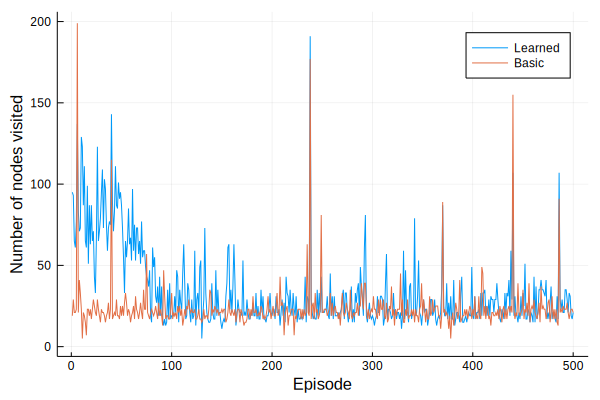

In [9]:
a, b = size(nodevisited)
x = 1:a

p1 = plot(x, nodevisited, xlabel="Episode", ylabel="Number of nodes visited", label = ["Learned" "Basic"], ylims = [0, 200])

## Benchmarking

This is used to better compare the performances of the heuristics. The learnedHeuristic is not updated and does not explore anymore. Therefore, the results are more significant, and you can also compare the time needed.

100.0%┣████████████████████████████┫ 200/200 [00:01<00:00, 177.7 it/s, Delta: 4]34/200 [00:00<00:01, 155.5 it/s, Delta: 14]55/200 [00:00<00:01, 165.7 it/s, Delta: 2]122/200 [00:01<00:00, 168.6 it/s, Delta: -14]143/200 [00:01<00:00, 166.8 it/s, Delta: 10]165/200 [00:01<00:00, 171.3 it/s, Delta: 2]


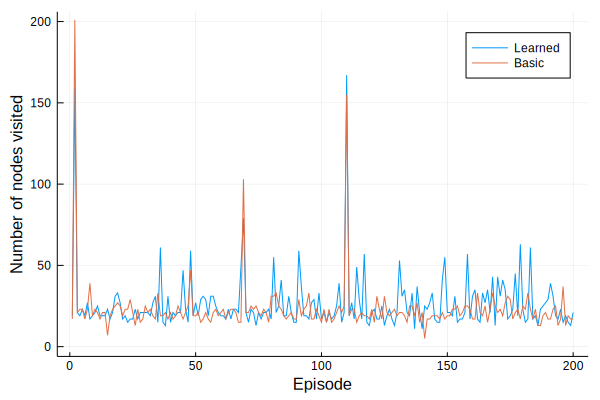

In [10]:
bestsolutions, nodevisited, timeneeded = SeaPearl.benchmark_solving(
    valueSelectionArray=[learnedHeuristic, heuristic_min], 
    generator=coloring_generator,
    nb_episodes=200,
    strategy=SeaPearl.DFSearch,
    variableHeuristic=variableSelection,
    verbose = false
)

# plot 
a, b = size(nodevisited)
x = 1:a

p2 = plot(x, nodevisited, xlabel="Episode", ylabel="Number of nodes visited", label = ["Learned" "Basic"], ylims = [0, 200])


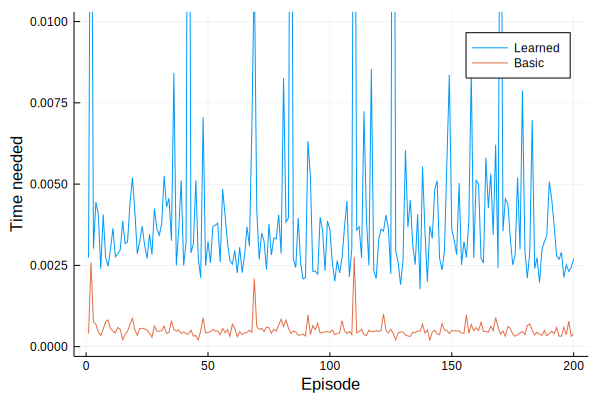

In [11]:
p3 = plot(x, timeneeded, xlabel="Episode", ylabel="Time needed", label = ["Learned" "Basic"], ylims = [0, 0.01])

## Customizing

The RL part of SeaPearl.jl was conceived to be modulable. It means you can tweak a lot of different things, including (but not limited to):
- The representation of your CP state. The default one is a tripartite graph with constraint, variable, and value nodes.
- The featurization of the nodes of your graph (if your representation is a graph).
- Your agent.
- The form of the output of your agent.
- The rewards given to your agent.

Here we'll learn how to customize the rewards and the featurization.

### Creating a new reward type

You only need to create a subtype of `SeaPearl.AbstractReward`.

In [12]:
struct BetterReward <: SeaPearl.AbstractReward end

And then we implement a few methods that correspond to different phases. We have `::SeaPearl.StepPhase`, `::SeaPearl.DecisionPhase`, `::SeaPearl.EndingPhase` for now.

In [13]:
function SeaPearl.set_reward!(::SeaPearl.StepPhase, lh::SeaPearl.LearnedHeuristic{SR, BetterReward, O}, model::SeaPearl.CPModel, symbol::Union{Nothing, Symbol}) where {
    SR <: SeaPearl.AbstractStateRepresentation,
    O <: SeaPearl.ActionOutput
}
    if !isnothing(lh.search_metrics.current_best) && lh.search_metrics.current_best == 3
        lh.current_reward = 0
    else
        lh.current_reward += 0
    end
    nothing
end

function SeaPearl.set_reward!(::SeaPearl.DecisionPhase, lh::SeaPearl.LearnedHeuristic{SR, BetterReward, O}, model::SeaPearl.CPModel) where {
    SR <: SeaPearl.AbstractStateRepresentation,
    O <: SeaPearl.ActionOutput
}
    if !isnothing(lh.search_metrics.current_best) && lh.search_metrics.current_best == 3
        lh.current_reward = 0
    else
        lh.current_reward += -1
    end
    nothing
end

function SeaPearl.set_reward!(::SeaPearl.EndingPhase, env::SeaPearl.LearnedHeuristic{SR, BetterReward, O}, model::SeaPearl.CPModel, symbol::Union{Nothing, Symbol}) where { 
    SR <: SeaPearl.AbstractStateRepresentation,
    O <: SeaPearl.ActionOutput
}
    nothing
end


### Creating a featurization type

Also pretty simple, let's create a feature type and implement a method.

In [14]:
struct BetterFeaturization <: SeaPearl.AbstractFeaturization end

function SeaPearl.featurize(sr::SeaPearl.DefaultStateRepresentation{BetterFeaturization})
    g = sr.cplayergraph
    features = zeros(Float32, nv(g), 16)
    for i in 1:nv(g)
        cp_vertex = SeaPearl.cpVertexFromIndex(g, i)
        if isa(cp_vertex, SeaPearl.VariableVertex)
            features[i, 1] = 1.
            if g.cpmodel.objective == cp_vertex.variable
                features[i, 6] = 1.
            end
        end
        if isa(cp_vertex, SeaPearl.ConstraintVertex)
            features[i, 2] = 1.
            constraint = cp_vertex.constraint
            if isa(constraint, SeaPearl.NotEqual)
                features[i, 4] = 1.
            end
            if isa(constraint, SeaPearl.LessOrEqual)
                features[i, 5] = 1.
            end
        end
        if isa(cp_vertex, SeaPearl.ValueVertex)
            features[i, 3] = 1.
            value = cp_vertex.value
            features[i, 6+value] = 1.
        end
    end
    features
end

### Putting it all together

We will basically do the same thing as before, just precising which types we will use to SeaPearl.
The first thing would be the "obscure" variables. The number of features is not 3 anymore, but 16. We also redefine the agent, it is exactly the same, but we want it to be resetted.

In [15]:
numInFeatures = 16
numberOfCPNodes = 1 + floor(Int64, coloring_generator.nb_nodes * ( 3 + coloring_generator.density ))
state_size = (numberOfCPNodes, numInFeatures + numberOfCPNodes + 2 + 1, 1)

agent = RL.Agent(
    policy = RL.QBasedPolicy(
        learner = SeaPearl.CPDQNLearner(
            approximator = RL.NeuralNetworkApproximator(
                model = SeaPearl.FlexGNN(
                    graphChain = Flux.Chain(
                        GeometricFlux.GCNConv(numInFeatures => 20),
                        GeometricFlux.GCNConv(20 => 20),
                    ),
                    nodeChain = Flux.Chain(
                        Flux.Dense(20, 20),
                    ),
                    outputLayer = Flux.Dense(20, 10)
                ),
                optimizer = ADAM(0.0005f0)
            ),
            target_approximator = RL.NeuralNetworkApproximator(
                model = SeaPearl.FlexGNN(
                    graphChain = Flux.Chain(
                        GeometricFlux.GCNConv(numInFeatures => 20),
                        GeometricFlux.GCNConv(20 => 20),
                    ),
                    nodeChain = Flux.Chain(
                        Flux.Dense(20, 20),
                    ),
                    outputLayer = Flux.Dense(20, 10)
                ),
                optimizer = ADAM(0.0005f0)
            ),
            loss_func = huber_loss,
            stack_size = nothing,
            γ = 0.9999f0,
            batch_size = 1, #32,
            update_horizon = 25,
            min_replay_history = 1,
            update_freq = 10,
            target_update_freq = 200,
            seed = 22,
        ), 
        explorer = SeaPearl.CPEpsilonGreedyExplorer(
            ϵ_stable = 0.001,
            kind = :exp,
            ϵ_init = 1.0,
            warmup_steps = 0,
            decay_steps = 1000,
            step = 1,
            is_break_tie = false, 
            seed = 33
        )
    ),
    trajectory = RL.CircularCompactSARTSATrajectory(
        capacity = 3000, 
        state_type = Float32, 
        state_size = state_size,
        action_type = Int,
        action_size = (),
        reward_type = Float32,
        reward_size = (),
        terminal_type = Bool,
        terminal_size = ()
    ),
    role = :DEFAULT_PLAYER
)

Agent{QBasedPolicy{CPDQNLearner{NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},typeof(huber_loss),Nothing,Random.MersenneTwister},CPEpsilonGreedyExplorer{:exp,false,Random.MersenneTwister}},Trajectory{(:state, :action, :reward, :terminal, :next_state, :next_action),Tuple{Array{Float32,3},Int64,Float32,Bool,Array{Float32,3},Int64},NamedTuple{(:reward, :terminal, :state, :action),Tuple{CircularArrayBuffer{Float32,1},CircularArrayBuffer{Bool,1},CircularArrayBuffer{Float32,4},CircularArrayBuffer{Int64,1}}}},Symbol}(QBasedPolicy{CPDQNLearner{NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},typeof(huber_loss),Nothing,Random.MersenneTwister},CPEpsilonGreedyExplorer{:exp,false,Random.MersenneTwister}}(CPDQNLearner{NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},typeof(huber_loss),Nothing,Random.MersenneTwister}(NeuralNetworkApproximator{SeaPearl.

Here would be the interesting line, we give to SeaPearl the two new types we just defined:

In [16]:
newLearnedHeuristic = SeaPearl.LearnedHeuristic{SeaPearl.DefaultStateRepresentation{BetterFeaturization}, BetterReward, SeaPearl.FixedOutput}(agent)

SeaPearl.LearnedHeuristic{SeaPearl.DefaultStateRepresentation{BetterFeaturization},BetterReward,SeaPearl.FixedOutput}(Agent{QBasedPolicy{CPDQNLearner{NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},typeof(huber_loss),Nothing,Random.MersenneTwister},CPEpsilonGreedyExplorer{:exp,false,Random.MersenneTwister}},Trajectory{(:state, :action, :reward, :terminal, :next_state, :next_action),Tuple{Array{Float32,3},Int64,Float32,Bool,Array{Float32,3},Int64},NamedTuple{(:reward, :terminal, :state, :action),Tuple{CircularArrayBuffer{Float32,1},CircularArrayBuffer{Bool,1},CircularArrayBuffer{Float32,4},CircularArrayBuffer{Int64,1}}}},Symbol}(QBasedPolicy{CPDQNLearner{NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},typeof(huber_loss),Nothing,Random.MersenneTwister},CPEpsilonGreedyExplorer{:exp,false,Random.MersenneTwister}}(CPDQNLearner{NeuralNetworkApproximator{SeaPearl.FlexGNN,ADAM},NeuralNetworkAppr

### Training, benchmarking and plotting

We are now ready to try our new environment.

100.0%┣█████████████████████████████┫ 500/500 [00:14<00:00, 36.4 it/s, Delta: 2]2/500 [00:00<03:38, 2.3 it/s, Delta: 74]5/500 [00:01<01:15, 6.6 it/s, Delta: 90]8/500 [00:01<00:55, 8.9 it/s, Delta: 104]12/500 [00:01<00:41, 11.9 it/s, Delta: 8]20/500 [00:01<00:35, 13.8 it/s, Delta: 68]22/500 [00:02<00:34, 13.9 it/s, Delta: 58]24/500 [00:02<00:34, 14.2 it/s, Delta: 78]26/500 [00:02<00:34, 14.0 it/s, Delta: 80]29/500 [00:02<00:33, 14.5 it/s, Delta: 46]31/500 [00:02<00:33, 14.4 it/s, Delta: 66]40/500 [00:03<00:30, 15.2 it/s, Delta: 84]47/500 [00:03<00:30, 15.2 it/s, Delta: 76]49/500 [00:03<00:30, 14.9 it/s, Delta: 78]60/500 [00:04<00:29, 15.0 it/s, Delta: 82]64/500 [00:04<00:29, 15.0 it/s, Delta: 82]66/500 [00:04<00:29, 15.0 it/s, Delta: 52]68/500 [00:04<00:29, 15.0 it/s, Delta: 88]77/500 [00:05<00:28, 15.0 it/s, Delta: 102]82/500 [00:05<00:28, 15.1 it/s, Delta: 74]84/500 [00:06<00:28, 15.1 it/s, Delta: 62]102/500 [00:06<00:25, 16.0 it/s, Delta: 32]106/500 [00:06<00:24, 16.3 it/s, Delta: 42

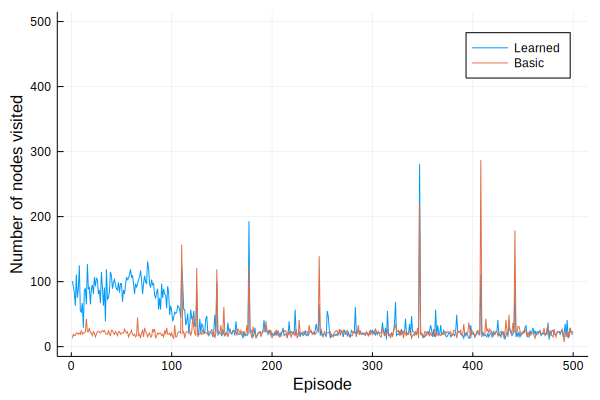

In [17]:
bestsolutions, nodevisited, timeneeded = SeaPearl.train!(
    valueSelectionArray=[newLearnedHeuristic, heuristic_min], 
    generator=coloring_generator,
    nb_episodes=500,
    strategy=SeaPearl.DFSearch,
    variableHeuristic=variableSelection,
    verbose = false
)

a, b = size(nodevisited)
x = 1:a

p1 = plot(x, nodevisited, xlabel="Episode", ylabel="Number of nodes visited", label = ["Learned" "Basic"], ylims = [0, 200])

100.0%┣███████████████████████████┫ 200/200 [00:01<00:00, 178.1 it/s, Delta: -6]36/200 [00:00<00:01, 128.0 it/s, Delta: 14]60/200 [00:00<00:01, 147.1 it/s, Delta: -2]90/200 [00:01<00:01, 172.3 it/s, Delta: 20]106/200 [00:01<00:01, 156.7 it/s, Delta: -10]131/200 [00:01<00:00, 164.3 it/s, Delta: 28]185/200 [00:01<00:00, 179.1 it/s, Delta: 4]


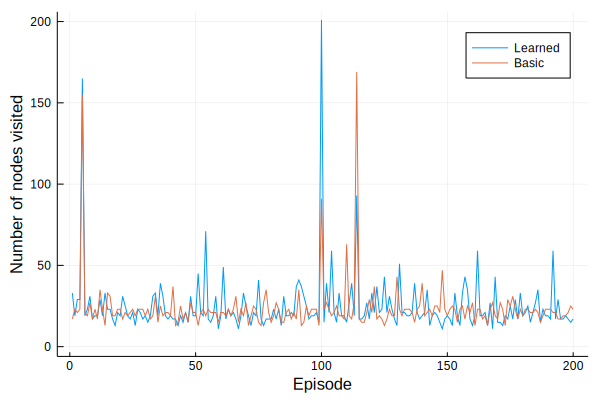

┌ Warning: C:\Users\ilanc\Dropbox\Stage-MTL\julia\SeaPearl.jl\examples\coloring is not an existing directory, Revise is not watching
└ @ Revise C:\Users\ilanc\.julia\packages\Revise\BqeJF\src\Revise.jl:636
┌ Warning: C:\Users\ilanc\Dropbox\Stage-MTL\julia\SeaPearl.jl\src\CP\variableselection is not an existing directory, Revise is not watching
└ @ Revise C:\Users\ilanc\.julia\packages\Revise\BqeJF\src\Revise.jl:636


In [18]:
bestsolutions, nodevisited, timeneeded = SeaPearl.benchmark_solving(
    valueSelectionArray=[learnedHeuristic, heuristic_min], 
    generator=coloring_generator,
    nb_episodes=200,
    strategy=SeaPearl.DFSearch,
    variableHeuristic=variableSelection,
    verbose = false
)

# plot 
a, b = size(nodevisited)
x = 1:a

p2 = plot(x, nodevisited, xlabel="Episode", ylabel="Number of nodes visited", label = ["Learned" "Basic"], ylims = [0, 200])
